In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import itertools
import math
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as accuracy
import graphviz 
from datetime import datetime, timedelta
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn import preprocessing, svm, metrics, tree, decomposition, svm
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, OrthogonalMatchingPursuit, RandomizedLogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler


# personal modules
import ml_pipeline_lch as ml
import ml_explore as exp
import ml_modeling as md


sns.set(style = "ticks", color_codes = True)
%matplotlib inline 

### Read and Pre-Process Data

#### Read Data

In [30]:
outcomes_df = ml.retrieve_data(filename = 'data/outcomes.csv', headers = True, set_ind = 0)

In [31]:
outcomes_df.head()

,is_exciting,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
projectid,,,,,,,,,,,
ffffc4f85b60efc5b52347df489d0238,f,NaN,f,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN
ffffac55ee02a49d1abc87ba6fc61135,f,f,t,t,f,t,f,f,57.0,0.0,7.0
ffff97ed93720407d70a2787475932b0,f,f,t,t,t,t,t,f,100.0,0.0,3.0
ffff418bb42fad24347527ad96100f81,f,f,f,t,t,f,f,f,100.0,0.0,1.0
ffff2d9c769c8fb5335e949c615425eb,t,t,t,t,t,f,t,f,63.0,6.0,2.0


In [32]:
outcomes_df.replace(to_replace='t', value=1, inplace=True)
outcomes_df.replace(to_replace='f', value=0, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/generic.py:4480: UserWarning: the "axis" argument is deprecated and will be removed inv0.13; this argument has no effect
  warnings.warn('the "axis" argument is deprecated '


In [33]:
outcomes_df.head()

,is_exciting,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
projectid,,,,,,,,,,,
ffffc4f85b60efc5b52347df489d0238,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
ffffac55ee02a49d1abc87ba6fc61135,0,0.0,1,1.0,0,1.0,0.0,0.0,57.0,0.0,7.0
ffff97ed93720407d70a2787475932b0,0,0.0,1,1.0,1,1.0,1.0,0.0,100.0,0.0,3.0
ffff418bb42fad24347527ad96100f81,0,0.0,0,1.0,1,0.0,0.0,0.0,100.0,0.0,1.0
ffff2d9c769c8fb5335e949c615425eb,1,1.0,1,1.0,1,0.0,1.0,0.0,63.0,6.0,2.0


In [34]:
projects_df = ml.retrieve_data(filename = 'data/projects.csv', headers = True, set_ind = 0)

In [35]:
project_info = pd.merge(projects_df, outcomes_df, how = 'outer', right_index = True, left_index = True)

In [36]:
project_info.head()

,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,...,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
projectid,,,,,,,,,,,,,,,,,,,,,
00001ccc0e81598c4bd86bacb94d7acb,96963218e74e10c3764a5cfb153e6fea,9f3f9f2c2da7edda5648ccd10554ed8c,1.709930e+11,41.807654,-87.673257,Chicago,IL,60609.0,urban,Pershing Elem Network,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,33.0,0.0,3.0
00002bff514104264a6b798356fdd893,3414541eb63108700b188648f866f483,cbaae3265eda78d330cb8ab1a9217071,6.032700e+10,35.203447,-118.840956,Arvin,CA,93203.0,NaN,Arvin Union School District,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,50.0,0.0,2.0
00002d691c05c51a5fdfbb2baef0ba25,7ad6abc974dd8b62773f79f6cbed48d5,56502bae9e97bab5eb54f9001878f469,6.029700e+10,34.137997,-118.062795,Arcadia,CA,91007.0,urban,Arcadia Unified School Dist,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,100.0,0.0,5.0
0000b38bbc7252972f7984848cf58098,e1aa1ae5301d0cda860c4d9c89c24919,30fcfca739b17be54ce3f1ee46980340,2.311400e+11,44.437717,-70.201292,Livermore,ME,4253.0,rural,Rsu 73,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,50.0,0.0,2.0
0000ee613c92ddc5298bf63142996a5c,e0c0a0214d3c2cfdc0ab6639bc3c5342,38bb0d62aa613c2f933de56c9df855b7,5.101260e+11,38.851982,-77.145287,Falls Church,VA,22041.0,suburban,Fairfax Co Public School Dist,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,4.0


In [6]:
project_info.date_posted.dtype

dtype('O')

In [37]:
project_info['date_posted'] = ml.convert_dates(project_info['date_posted'])

In [38]:
project_info['year'] = project_info['date_posted'].apply(lambda x: x.year)

In [39]:
project_info['year'] = project_info[project_info['year'].isin([2011, 2012, 2013])]

In [40]:
pd.Series(project_info.columns)

0                                     teacher_acctid
1                                           schoolid
2                                      school_ncesid
3                                    school_latitude
4                                   school_longitude
5                                        school_city
6                                       school_state
7                                         school_zip
8                                       school_metro
9                                    school_district
10                                     school_county
11                                    school_charter
12                                     school_magnet
13                                 school_year_round
14                                       school_nlns
15                                       school_kipp
16                      school_charter_ready_promise
17                                    teacher_prefix
18                         teacher_teach_for_a

In [41]:
project_info.describe().round(3).transpose()

,count,mean,std,min,25%,50%,75%,max
school_ncesid,621362.0,2.608577e+11,1.589754e+11,1.000050e+10,1.000230e+11,2.615730e+11,3.704720e+11,6.100009e+11
school_latitude,664098.0,3.724100e+01,4.668000e+00,1.824900e+01,3.403800e+01,3.766200e+01,4.075900e+01,6.725800e+01
school_longitude,664098.0,-9.334500e+01,1.776200e+01,-1.766350e+02,-1.120030e+02,-8.768100e+01,-7.919300e+01,-6.662800e+01
school_zip,664094.0,5.292645e+04,3.119374e+04,4.100000e+02,2.758900e+04,5.070200e+04,8.504300e+04,9.995000e+04
fulfillment_labor_materials,629016.0,2.749600e+01,8.663000e+00,9.000000e+00,1.700000e+01,3.000000e+01,3.500000e+01,3.500000e+01
total_price_excluding_optional_support,664098.0,5.420420e+02,1.267738e+04,0.000000e+00,2.672000e+02,4.110000e+02,5.864900e+02,1.025002e+07
total_price_including_optional_support,664098.0,6.447130e+02,1.545863e+04,0.000000e+00,3.175000e+02,4.878400e+02,6.963880e+02,1.250002e+07
students_reached,663952.0,9.723400e+01,2.283328e+03,0.000000e+00,2.200000e+01,3.000000e+01,1.000000e+02,9.999990e+05
is_exciting,619326.0,5.900000e-02,2.360000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
at_least_1_teacher_referred_donor,524928.0,2.370000e-01,4.260000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [42]:
# create quick reference for accessing columns
col_ref = ml.create_col_ref(project_info)
col_ref

{'teacher_acctid': 0,
 'schoolid': 1,
 'school_ncesid': 2,
 'school_latitude': 3,
 'school_longitude': 4,
 'school_city': 5,
 'school_state': 6,
 'school_zip': 7,
 'school_metro': 8,
 'school_district': 9,
 'school_county': 10,
 'school_charter': 11,
 'school_magnet': 12,
 'school_year_round': 13,
 'school_nlns': 14,
 'school_kipp': 15,
 'school_charter_ready_promise': 16,
 'teacher_prefix': 17,
 'teacher_teach_for_america': 18,
 'teacher_ny_teaching_fellow': 19,
 'primary_focus_subject': 20,
 'primary_focus_area': 21,
 'secondary_focus_subject': 22,
 'secondary_focus_area': 23,
 'resource_type': 24,
 'poverty_level': 25,
 'grade_level': 26,
 'fulfillment_labor_materials': 27,
 'total_price_excluding_optional_support': 28,
 'total_price_including_optional_support': 29,
 'students_reached': 30,
 'eligible_double_your_impact_match': 31,
 'eligible_almost_home_match': 32,
 'date_posted': 33,
 'is_exciting': 34,
 'at_least_1_teacher_referred_donor': 35,
 'fully_funded': 36,
 'at_least_1_gr

In [43]:
# check column types
project_info.dtypes

teacher_acctid                                            object
schoolid                                                  object
school_ncesid                                            float64
school_latitude                                          float64
school_longitude                                         float64
school_city                                               object
school_state                                              object
school_zip                                               float64
school_metro                                              object
school_district                                           object
school_county                                             object
school_charter                                            object
school_magnet                                             object
school_year_round                                         object
school_nlns                                               object
school_kipp              

In [44]:
maxes = ml.view_max_mins(project_info, max = True)
maxes.tail().round(2)

,school_ncesid,school_latitude,school_longitude,school_zip,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,is_exciting,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
0.996,5.509600e+11,47.85,-70.29,98801.00,35.0,4084.85,4851.45,999.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,100.0,13.0,37.0
0.997,5.512360e+11,48.32,-70.24,99114.00,35.0,4913.58,5870.81,999.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,100.0,15.0,41.0
0.998,5.514640e+11,57.79,-70.07,99503.00,35.0,6217.20,7407.79,999.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,100.0,17.0,47.0
0.999,5.516320e+11,61.20,-69.00,99516.91,35.0,9169.52,10901.86,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,100.0,22.0,57.0
1.000,6.100009e+11,67.26,-66.63,99950.00,35.0,10250017.00,12500020.73,999999.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,100.0,151.0,304.0


In [45]:
likely_outliers_upper = ml.view_likely_outliers(project_info)
likely_outliers_upper.tail()

,school_ncesid,school_latitude,school_longitude,school_zip,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,is_exciting,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
0.996,3.856904e-09,0.002710,-0.004339,0.002201,0.0,0.164562,0.158605,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.057143
0.997,5.009406e-04,0.009803,-0.000795,0.003168,0.0,0.202879,0.210113,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.153846,0.108108
0.998,4.136178e-04,0.196004,-0.002392,0.003925,0.0,0.265311,0.261801,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.133333,0.146341
0.999,3.046438e-04,0.058925,-0.015290,0.000140,0.0,0.474861,0.471674,0.001001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.294118,0.212766
1.000,1.058113e-01,0.099021,-0.034329,0.004352,0.0,1116.836330,1145.595306,998.999000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.863636,4.333333


In [46]:
mins = ml.view_max_mins(project_info, max = False)
mins

,school_ncesid,school_latitude,school_longitude,school_zip,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,is_exciting,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
0.000,1.000050e+10,18.249140,-176.634989,410.0,9.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.001,1.000050e+10,21.268626,-158.183854,1109.0,9.0,66.63000,81.26000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.002,1.003900e+10,21.350264,-157.979734,1571.0,9.0,94.30000,115.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.003,1.010200e+10,21.453017,-157.728836,1701.0,9.0,102.00000,124.39000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.004,1.016400e+10,25.397676,-155.096330,1841.0,9.0,106.60000,130.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.005,1.019200e+10,25.632741,-149.783157,1902.0,9.0,109.68485,133.76000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.006,1.023700e+10,25.730276,-124.272108,2118.0,9.0,113.00000,137.80000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.007,1.026400e+10,25.777018,-123.820824,2121.0,9.0,115.89679,141.26000,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.008,1.030300e+10,25.820618,-123.144696,2126.0,9.0,118.14776,143.90000,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.009,1.035100e+10,25.868484,-123.010372,2130.0,9.0,120.39000,146.67619,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
likely_outliers_lower = ml.view_likely_outliers(project_info, max = False)
likely_outliers_lower

,school_ncesid,school_latitude,school_longitude,school_zip,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,is_exciting,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.001,7.459626e-08,0.165459,-0.104459,1.704878,0.0,inf,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.002,3.849657e-03,0.003838,-0.001290,0.416592,0.0,0.415278,0.415210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.003,6.275555e-03,0.004813,-0.001588,0.082750,0.0,0.081654,0.081652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.004,6.137413e-03,0.183874,-0.016690,0.082305,0.0,0.045098,0.045100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.005,2.754833e-03,0.009255,-0.034257,0.033134,0.0,0.028939,0.028923,inf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.006,4.415249e-03,0.003805,-0.170320,0.113565,0.0,0.030224,0.030203,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.007,2.637507e-03,0.001817,-0.003631,0.001416,0.0,0.025635,0.025109,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.008,3.799696e-03,0.001691,-0.005461,0.002357,0.0,0.019422,0.018689,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.009,4.658853e-03,0.001854,-0.001091,0.001881,0.0,0.018978,0.019292,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
manip_df = project_info[project_info.columns]

In [52]:
# total price and students reached values should not be inf 
ml.remove_over_under_threshold(manip_df, col = 'total_price_excluding_optional_support', min_val = 0, max_val = False, lwr_threshold = 0.001, upr_threshold = False)
ml.remove_over_under_threshold(manip_df, col = 'total_price_including_optional_support', min_val = 0, max_val = False, lwr_threshold = 0.001, upr_threshold = False)
ml.remove_over_under_threshold(manip_df, col = 'students_reached', min_val = 0, max_val = False, lwr_threshold = 0.005, upr_threshold = False)


In [53]:
# check that expected values were removed
likely_outliers_lower_post = ml.view_likely_outliers(manip_df, max = False)
likely_outliers_lower_post

,school_ncesid,school_latitude,school_longitude,school_zip,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,is_exciting,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.001,7.459626e-08,0.165459,-0.104459,1.704878,0.0,0.414611,0.410657,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.002,3.849657e-03,0.003838,-0.001290,0.416592,0.0,0.082165,0.085144,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.003,6.275555e-03,0.004813,-0.001588,0.082750,0.0,0.043725,0.043010,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.004,6.137413e-03,0.183874,-0.016690,0.082305,0.0,0.030246,0.030754,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.005,2.754833e-03,0.009255,-0.034257,0.033134,0.0,0.030128,0.029462,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.006,4.415249e-03,0.003805,-0.170320,0.113565,0.0,0.025186,0.026077,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.007,2.637507e-03,0.001817,-0.003631,0.001416,0.0,0.018744,0.018689,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.008,3.799696e-03,0.001691,-0.005461,0.002357,0.0,0.019313,0.018902,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.009,4.658853e-03,0.001854,-0.001091,0.001881,0.0,0.015297,0.014732,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
ml.print_null_freq(manip_df)

value                                            False   True 
variable                                                      
at_least_1_green_donation                       524928  139170
at_least_1_teacher_referred_donor               524928  139170
date_posted                                     664098       0
donation_from_thoughtful_donor                  524928  139170
eligible_almost_home_match                      664098       0
eligible_double_your_impact_match               664098       0
fulfillment_labor_materials                     629016   35082
fully_funded                                    619326   44772
grade_level                                     664089       9
great_chat                                      619326   44772
great_messages_proportion                       439487  224611
is_exciting                                     619326   44772
non_teacher_referred_count                      524928  139170
one_non_teacher_referred_donor_giving_100_plus  524928 

In [ ]:
pd.get_dummies(manip_df, prefix="dummy", prefix_sep='_', dummy_na=False, columns=None

In [22]:
def record_nulls(df):
    for col in list(df.columns):
        title = col + "_was_null"
        df[title] = df[col].isnull().astype(int)
    df = df.loc[:, (df != 0).any(axis=0)]

In [23]:
record_nulls(manip_df)

In [24]:
manip_df.head()

,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,...,fully_funded_was_null,at_least_1_green_donation_was_null,great_chat_was_null,three_or_more_non_teacher_referred_donors_was_null,one_non_teacher_referred_donor_giving_100_plus_was_null,donation_from_thoughtful_donor_was_null,great_messages_proportion_was_null,teacher_referred_count_was_null,non_teacher_referred_count_was_null,year_was_null
projectid,,,,,,,,,,,,,,,,,,,,,
00001ccc0e81598c4bd86bacb94d7acb,96963218e74e10c3764a5cfb153e6fea,9f3f9f2c2da7edda5648ccd10554ed8c,1.709930e+11,41.807654,-87.673257,Chicago,IL,60609.0,urban,Pershing Elem Network,...,0,0,0,0,0,0,0,0,0,0
00002bff514104264a6b798356fdd893,3414541eb63108700b188648f866f483,cbaae3265eda78d330cb8ab1a9217071,6.032700e+10,35.203447,-118.840956,Arvin,CA,93203.0,NaN,Arvin Union School District,...,0,0,0,0,0,0,0,0,0,1
00002d691c05c51a5fdfbb2baef0ba25,7ad6abc974dd8b62773f79f6cbed48d5,56502bae9e97bab5eb54f9001878f469,6.029700e+10,34.137997,-118.062795,Arcadia,CA,91007.0,urban,Arcadia Unified School Dist,...,0,0,0,0,0,0,0,0,0,1
0000b38bbc7252972f7984848cf58098,e1aa1ae5301d0cda860c4d9c89c24919,30fcfca739b17be54ce3f1ee46980340,2.311400e+11,44.437717,-70.201292,Livermore,ME,4253.0,rural,Rsu 73,...,0,0,0,0,0,0,0,0,0,0
0000ee613c92ddc5298bf63142996a5c,e0c0a0214d3c2cfdc0ab6639bc3c5342,38bb0d62aa613c2f933de56c9df855b7,5.101260e+11,38.851982,-77.145287,Falls Church,VA,22041.0,suburban,Fairfax Co Public School Dist,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# fill null values for which zero where it is most likely true value
ml.basic_fill_vals(manip_df, "at_least_1_green_donation",  method = "replace", replace_with = "f")
ml.basic_fill_vals(manip_df, "at_least_1_teacher_referred_donor",  method = "replace", replace_with = "f")
ml.basic_fill_vals(manip_df, "donation_from_thoughtful_donor",  method = "replace", replace_with = "f")
ml.basic_fill_vals(manip_df, "fully_funded", method = "replace", replace_with = "False")
ml.basic_fill_vals(manip_df, "great_chat", method = "zeros")
ml.basic_fill_vals(manip_df, "is_exciting", method = "replace", replace_with = "False")
ml.basic_fill_vals(manip_df, "one_non_teacher_referred_donor_giving_100_plus", method = "zeros")
ml.basic_fill_vals(manip_df, "three_or_more_non_teacher_referred_donors", method = "zeros")



In [26]:
ml.print_null_freq(manip_df)

value                                                False   True 
variable                                                          
at_least_1_green_donation                           664098       0
at_least_1_green_donation_was_null                  664098       0
at_least_1_teacher_referred_donor                   664098       0
at_least_1_teacher_referred_donor_was_null          664098       0
date_posted                                         664098       0
date_posted_was_null                                664098       0
donation_from_thoughtful_donor                      664098       0
donation_from_thoughtful_donor_was_null             664098       0
eligible_almost_home_match                          664098       0
eligible_almost_home_match_was_null                 664098       0
eligible_double_your_impact_match                   664098       0
eligible_double_your_impact_match_was_null          664098       0
fulfillment_labor_materials                         629016   3

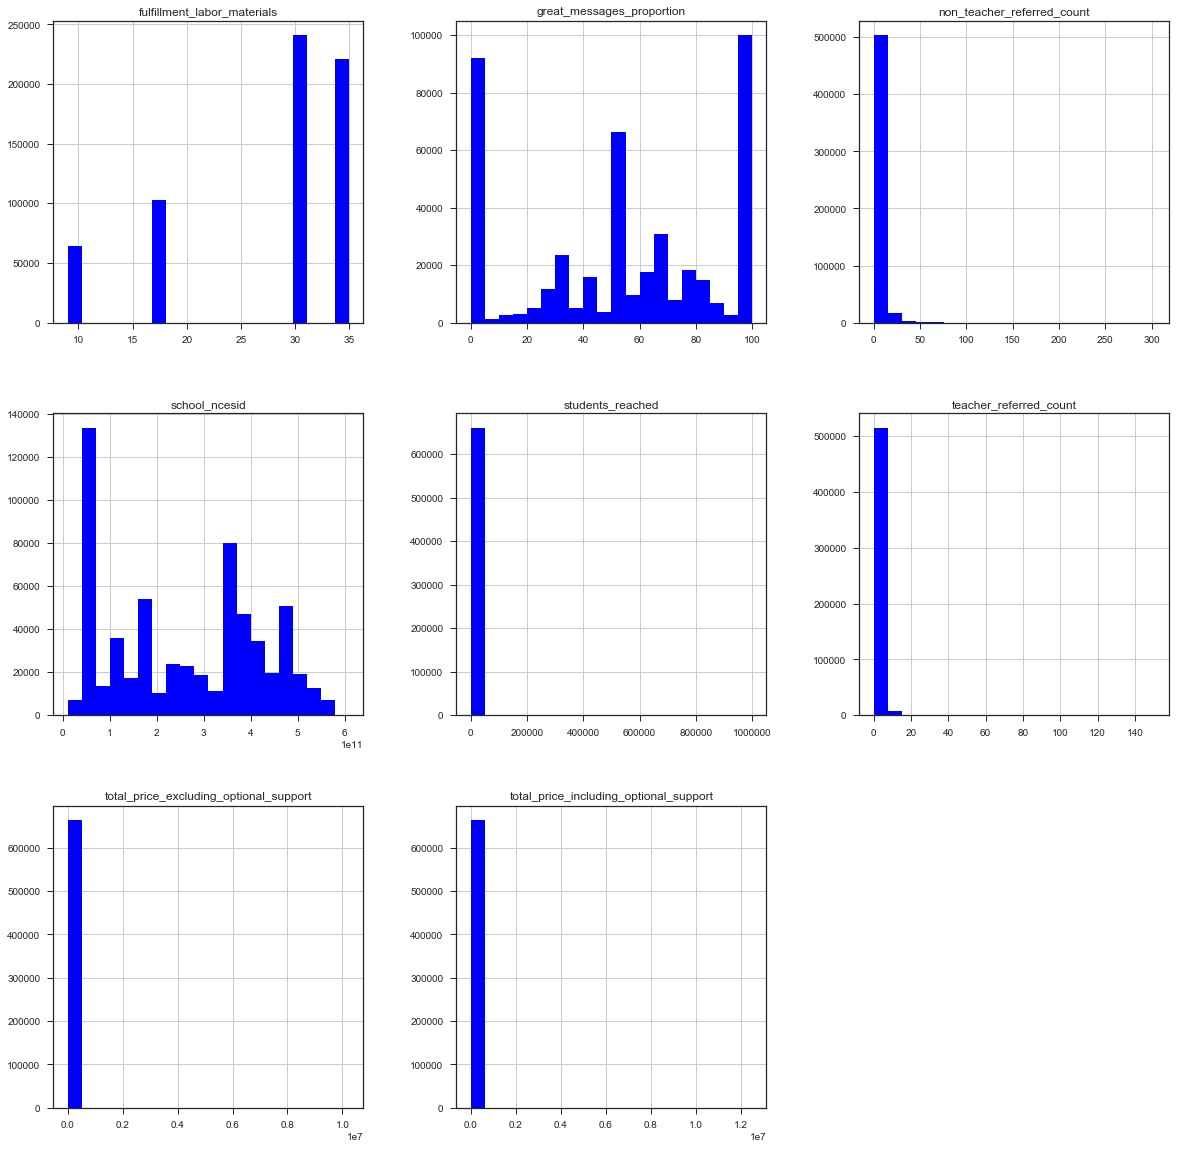

In [27]:
exp.view_dist(manip_df, geo_columns= True,
             fig_size = (20, 20),
             labels = ["Feature Distributions", "Feature", "Frequency"])


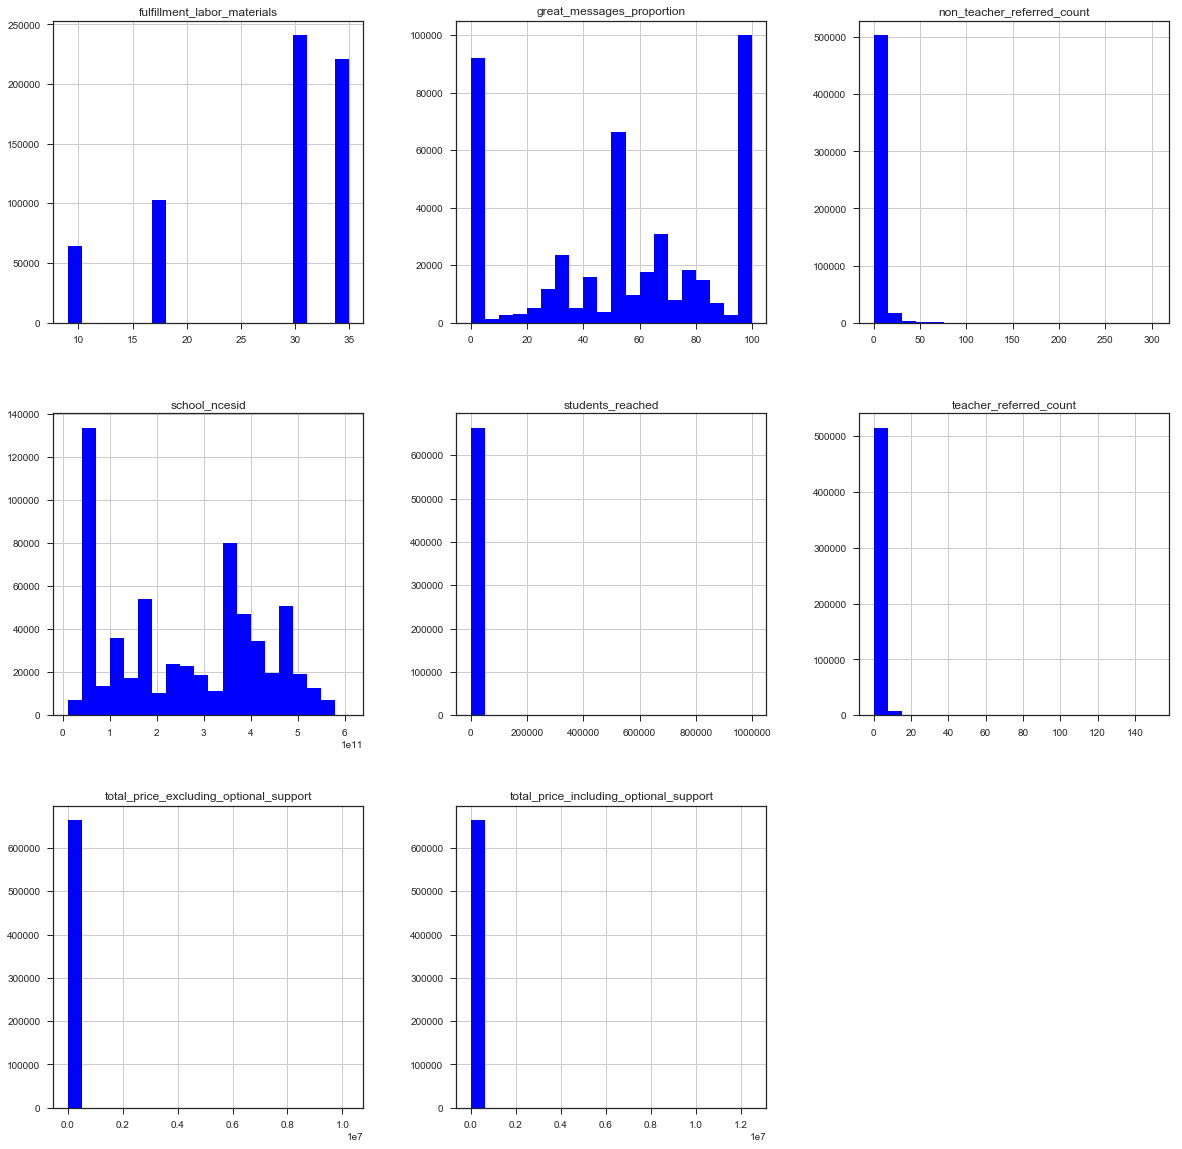

In [28]:
exp.view_dist(project_info, geo_columns= True,
             fig_size = (20, 20),
             labels = ["Feature Distributions", "Feature", "Frequency"])


In [ ]:
params_test = { 
    'RF':{'n_estimators': [1], 'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10], 'n_jobs': [-1]},
    'LR': { 'penalty': ['l1'], 'C': [0.01]},
    'SGD': { 'loss': ['perceptron'], 'penalty': ['l2']},
    'ET': { 'n_estimators': [1], 'criterion' : ['gini'] ,'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10], 'n_jobs': [-1]},
    'AB': { 'algorithm': ['SAMME'], 'n_estimators': [1]},
    'GB': {'n_estimators': [1], 'learning_rate' : [0.1],'subsample' : [0.5], 'max_depth': [1]},
    'NB' : {},
    'DT': {'criterion': ['gini'], 'max_depth': [1], 'max_features': [None],'min_samples_split': [10]},
    'SVM' :{'C' :[0.01],'kernel':['linear']},
    'KNN' :{'n_neighbors': [5],'weights': ['uniform'],'algorithm': ['auto']}
           }

In [63]:
small_grid = { 
    "Random Forest":{'n_estimators': [100, 10000], 'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10], 'n_jobs':[-1]},
    "Logistic Regression": { 'penalty': ['l1','l2'], 'C': [0.00001,0.001,0.1,1,10]},
    "Naive Bayes" : {},
    "Decision Tree": {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100], 'max_features': [None,'sqrt','log2'],'min_samples_split': [2,5,10]},
    'SVM' :{'C' :[0.00001,0.0001,0.001,0.01,0.1,1,10],'kernel':['linear']},
    'KNN' :{'n_neighbors': [1,5,10,25,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']}
           }

In [74]:
for clf_type, params in small_grid.items():
    print(clf_type)
    print(params)
    print()
    for tried in list(itertools.product(params.values())):
        print(tried)
    

Random Forest
{'n_estimators': [100, 10000], 'max_depth': [5, 50], 'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 10], 'n_jobs': [-1]}

([100, 10000],)
([5, 50],)
(['sqrt', 'log2'],)
([2, 10],)
([-1],)
Logistic Regression
{'penalty': ['l1', 'l2'], 'C': [1e-05, 0.001, 0.1, 1, 10]}

(['l1', 'l2'],)
([1e-05, 0.001, 0.1, 1, 10],)
Naive Bayes
{}

Decision Tree
{'criterion': ['gini', 'entropy'], 'max_depth': [1, 5, 10, 20, 50, 100], 'max_features': [None, 'sqrt', 'log2'], 'min_samples_split': [2, 5, 10]}

(['gini', 'entropy'],)
([1, 5, 10, 20, 50, 100],)
([None, 'sqrt', 'log2'],)
([2, 5, 10],)
SVM
{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10], 'kernel': ['linear']}

([1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10],)
(['linear'],)
KNN
{'n_neighbors': [1, 5, 10, 25, 50, 100], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree']}

([1, 5, 10, 25, 50, 100],)
(['uniform', 'distance'],)
(['auto', 'ball_tree', 'kd_tree'],)


In [114]:
# parameters for looping sourced from example at https://github.com/rayidghani/magicloops/blob/master/mlfunctions.py
dt_params = {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100], 'max_features': [None, 'sqrt','log2'],'min_samples_split': [2,5,10]}
dt_parameter = list(dt_params.keys())
# for params in list(itertools.product(*dt_params.values())):
#     print(params)
list_params = list(itertools.product(*dt_params.values()))

In [115]:
dt_parameter

['criterion', 'max_depth', 'max_features', 'min_samples_split']

In [116]:
list_params

[('gini', 1, None, 2),
 ('gini', 1, None, 5),
 ('gini', 1, None, 10),
 ('gini', 1, 'sqrt', 2),
 ('gini', 1, 'sqrt', 5),
 ('gini', 1, 'sqrt', 10),
 ('gini', 1, 'log2', 2),
 ('gini', 1, 'log2', 5),
 ('gini', 1, 'log2', 10),
 ('gini', 5, None, 2),
 ('gini', 5, None, 5),
 ('gini', 5, None, 10),
 ('gini', 5, 'sqrt', 2),
 ('gini', 5, 'sqrt', 5),
 ('gini', 5, 'sqrt', 10),
 ('gini', 5, 'log2', 2),
 ('gini', 5, 'log2', 5),
 ('gini', 5, 'log2', 10),
 ('gini', 10, None, 2),
 ('gini', 10, None, 5),
 ('gini', 10, None, 10),
 ('gini', 10, 'sqrt', 2),
 ('gini', 10, 'sqrt', 5),
 ('gini', 10, 'sqrt', 10),
 ('gini', 10, 'log2', 2),
 ('gini', 10, 'log2', 5),
 ('gini', 10, 'log2', 10),
 ('gini', 20, None, 2),
 ('gini', 20, None, 5),
 ('gini', 20, None, 10),
 ('gini', 20, 'sqrt', 2),
 ('gini', 20, 'sqrt', 5),
 ('gini', 20, 'sqrt', 10),
 ('gini', 20, 'log2', 2),
 ('gini', 20, 'log2', 5),
 ('gini', 20, 'log2', 10),
 ('gini', 50, None, 2),
 ('gini', 50, None, 5),
 ('gini', 50, None, 10),
 ('gini', 50, 'sqrt',

In [117]:
all_dicts = []
for params in list_params:
    kwargs_dict = dict(zip(dt_parameter, params))
    all_dicts.append(kwargs_dict)


In [120]:
all_dicts

[{'criterion': 'gini',
  'max_depth': 1,
  'max_features': None,
  'min_samples_split': 2},
 {'criterion': 'gini',
  'max_depth': 1,
  'max_features': None,
  'min_samples_split': 5},
 {'criterion': 'gini',
  'max_depth': 1,
  'max_features': None,
  'min_samples_split': 10},
 {'criterion': 'gini',
  'max_depth': 1,
  'max_features': 'sqrt',
  'min_samples_split': 2},
 {'criterion': 'gini',
  'max_depth': 1,
  'max_features': 'sqrt',
  'min_samples_split': 5},
 {'criterion': 'gini',
  'max_depth': 1,
  'max_features': 'sqrt',
  'min_samples_split': 10},
 {'criterion': 'gini',
  'max_depth': 1,
  'max_features': 'log2',
  'min_samples_split': 2},
 {'criterion': 'gini',
  'max_depth': 1,
  'max_features': 'log2',
  'min_samples_split': 5},
 {'criterion': 'gini',
  'max_depth': 1,
  'max_features': 'log2',
  'min_samples_split': 10},
 {'criterion': 'gini',
  'max_depth': 5,
  'max_features': None,
  'min_samples_split': 2},
 {'criterion': 'gini',
  'max_depth': 5,
  'max_features': None,


In [131]:
args = all_dicts[0]
dec_tree = DecisionTreeClassifier(**args)


In [151]:
x = {'A': [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0], 'B': ['pink', 'blue','pink', 'blue', 'pink', 'pink', 'blue', 'blue',  'blue','pink', 'blue', 'pink', 'blue','pink']}

In [152]:
y = {'C': [1, 9, 1, 0, 1, 4, 0, 6, 1, 7, 1, 1, 3, 1]}

In [153]:
features = pd.DataFrame(x)
features

,A,B
0,1,pink
1,0,blue
2,1,pink
3,0,blue
4,1,pink
5,1,pink
6,0,blue
7,1,blue
8,0,blue
9,1,pink


In [154]:
features = pd.get_dummies(features, 'B')
features

,A,B_blue,B_pink
0,1,0,1
1,0,1,0
2,1,0,1
3,0,1,0
4,1,0,1
5,1,0,1
6,0,1,0
7,1,1,0
8,0,1,0
9,1,0,1


In [155]:
ys = pd.DataFrame(y)
ys

,C
0,1
1,9
2,1
3,0
4,1
5,4
6,0
7,6
8,1
9,7


In [156]:
x_train, x_test, y_train, y_test = train_test_split(features, ys, test_size = 0.2, random_state = 0)

In [157]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(11, 3)
(11, 1)
(3, 3)
(3, 1)


In [158]:
dec_tree.fit(x_train, y_train)
train_pred = dec_tree.predict(x_train)
test_pred = dec_tree.predict(x_test)
train_acc = accuracy(x_train, y_train)
test_acc = accuracy(x_test, y_test)
print(train_acc, test_acc)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets